In [7]:
#!pip install tensorflow librosa

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JorgeRuizDev/SpotMyFM/blob/main/Ludwig/notebooks/gtzan/gtzan_demo_train.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/JorgeRuizDev/SpotMyFM/blob/main/Ludwig/notebooks/gtzan/gtzan_demo_train.ipynb)

In [8]:
# Imports
import tensorflow as tf
from tensorflow.python.keras.api import keras
from tensorflow.python.keras.api.keras.preprocessing.image import ImageDataGenerator

import os
from pathlib import Path
from IPython.core.display import HTML, display

import librosa

import numpy as np

from typing import Union, Any

In [28]:
def download():
  #!pip install kaggle
  import os
  os.environ['KAGGLE_USERNAME'] = ""
  os.environ['KAGGLE_KEY'] = ""
  !kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
  !unzip -qq /content/gtzan-dataset-music-genre-classification.zip
#download()

In [10]:
print(tf. __version__)
print(tf.config.list_physical_devices('GPU'))


2.7.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
# CONFIG

SAMPLE_RATE = None

# Dataset:
DATASET_PATH = "/content/Data"

GENRES_PATH = f"{DATASET_PATH}/genres_original"

GENRES = os.listdir(GENRES_PATH)

# Training
BATCH_SIZE = 20


In [12]:
GENRE_2_LABEL = {k: v for v, k in enumerate(GENRES)}
LABEL_2_GENRE = {v: k for k,v in GENRE_2_LABEL.items()}
print(f"Genre to Label Dict: {GENRE_2_LABEL}")
print(f"Label to Genre Dict: {LABEL_2_GENRE}")

Genre to Label Dict: {'metal': 0, 'disco': 1, 'country': 2, 'blues': 3, 'jazz': 4, 'hiphop': 5, 'reggae': 6, 'pop': 7, 'rock': 8, 'classical': 9}
Label to Genre Dict: {0: 'metal', 1: 'disco', 2: 'country', 3: 'blues', 4: 'jazz', 5: 'hiphop', 6: 'reggae', 7: 'pop', 8: 'rock', 9: 'classical'}


In [13]:
if not len(list(Path(f"{DATASET_PATH}/genres_original/disco").glob("*.wav"))) >= 100:
  print(f"""
    No subfolder 'genres_original/disco' found under {DATASET_PATH}.
    Please download the datasate from https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification and
    unzip it under {DATASET_PATH}.
  """)
  raise IOError


In [14]:
def preprocess_track(y: Union[np.ndarray, Any], sr=SAMPLE_RATE):
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.amplitude_to_db(S)
    return log_S[:, :1290]

In [15]:
def load_data(genre_path=GENRES_PATH):
    track_input = []
    labels = []
    for genre in GENRES:
        genre_folder = f"{genre_path}/{genre}"
        label = GENRE_2_LABEL[genre]
        for track in os.listdir(genre_folder):

            if (track == "jazz.00054.wav"):
                # This track is broken 
                continue

            y, sr = librosa.load(f"{genre_folder}/{track}", sr=SAMPLE_RATE)
            
            track = preprocess_track(y, sr)
            
            # Esto es una chapuza: 
            track_input.append(track)
            labels.append(label)



    return np.array(track_input), np.array(labels)

In [16]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [17]:
tracks_, labels_ = load_data()

In [18]:
tracks, labels = tracks_, labels_

shuffled_tracks , shuffled_labels = unison_shuffled_copies(tracks, labels)

tracks = np.expand_dims(shuffled_tracks, axis=3)
labels = shuffled_labels


train_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

train_generator = train_datagen.flow(tracks, labels, batch_size=BATCH_SIZE, subset="training")
validation_generator = train_datagen.flow(tracks, labels, batch_size=BATCH_SIZE, subset="validation")



In [23]:
model = keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), activation=keras.layers.LeakyReLU(alpha=0.01), input_shape=(128, 1290, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (5,5), activation=keras.layers.LeakyReLU(alpha=0.01), input_shape=(128, 1290, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (5,5), activation=keras.layers.LeakyReLU(alpha=0.01), input_shape=(128, 1290, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),                                       
    
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(256, activation=keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dense(128, activation=keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dense(64, activation=keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dense(10, activation='softmax'),  
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_generator,
                     validation_data = validation_generator, 
                     #validation_steps = len(tracks) // BATCH_SIZE,
                     epochs=20 
                     )

Epoch 1/20
40/40 [==============================] - 11s 227ms/step - loss: 2.2388 - accuracy: 0.1600 - val_loss: 2.1366 - val_accuracy: 0.1658
Epoch 2/20
40/40 [==============================] - 9s 218ms/step - loss: 2.0683 - accuracy: 0.2313 - val_loss: 2.2268 - val_accuracy: 0.2613
Epoch 3/20
40/40 [==============================] - 9s 218ms/step - loss: 1.9531 - accuracy: 0.2862 - val_loss: 2.5014 - val_accuracy: 0.2261
Epoch 4/20
40/40 [==============================] - 9s 219ms/step - loss: 1.8423 - accuracy: 0.3325 - val_loss: 1.7558 - val_accuracy: 0.3970
Epoch 5/20
40/40 [==============================] - 9s 219ms/step - loss: 1.6998 - accuracy: 0.3850 - val_loss: 1.7438 - val_accuracy: 0.3769
Epoch 6/20
40/40 [==============================] - 9s 219ms/step - loss: 1.5323 - accuracy: 0.4650 - val_loss: 1.6026 - val_accuracy: 0.4422
Epoch 7/20
40/40 [==============================] - 9s 218ms/step - loss: 1.3814 - accuracy: 0.5200 - val_loss: 1.8546 - val_accuracy: 0.3618
Epoch

In [27]:
import requests
from IPython import display
url = input()
r = requests.get(url, allow_redirects=True)
open('test.mp3', 'wb').write(r.content)

Y, sr = librosa.load('test.mp3')

track = preprocess_track(Y, sr)

pred = model.predict(np.expand_dims([track], axis=3))
print(pred)
print(LABEL_2_GENRE.get(np.argmax(pred)))

display.Audio("test.mp3")

https://p.scdn.co/mp3-preview/60f498858dd25f6a8c6fbb9dcdc58341656b5cce?cid=7c4c757477e2485ea783355e72a900af


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
blues


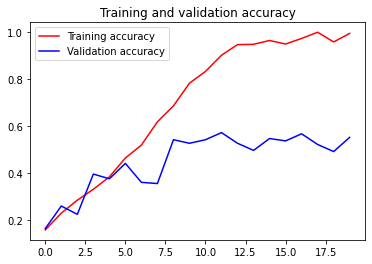

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()